In [1]:
import SimPEG as simpeg
from SimPEG import NSEM
from glob import glob
import numpy as np, sys, matplotlib.pyplot as plt
# sys.path.append('/home/gudni/Dropbox/Work/UBCwork/SyntheticModels/SynGeothermalStructures/ThesisModels')
# import synhelpFunc

In [2]:
def convergeCurves(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    phim = np.array([res['phi_m'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.semilogy(x,phid[ind],'bx--')
    ax1.set_ylabel('phi_d', color='b')
    plt.hlines(len(resList[0]['dpred'])*.75,0,len(x),colors='g',linestyles='-.')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    ax2 = ax1.twinx()          
    ax2.semilogy(x,phim[ind],'rx--',)
    ax2.set_ylabel('phi_m', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.show()
    
def tikanovCurve(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    phim = np.array([res['phi_m'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.loglog(phim[ind],phid[ind],'bx--')
    ax1.set_ylabel('phi_d')
    ax1.set_xlabel('phi_m')
    plt.hlines(len(resList[0]['dpred'])*.75,np.min(phim),np.max(phim),colors='g',linestyles='-.')
    plt.show()
    
def allconvergeCurves(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    phim = np.array([res['phi_m'] for res in resList]).T
    phims = np.array([res['phi_ms'] for res in resList]).T
    phimx = np.array([res['phi_mx'] for res in resList]).T
    phimy = np.array([res['phi_my'] for res in resList]).T
    phimz = np.array([res['phi_mz'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.semilogy(x,phid[ind],'bx--',label='phid')
    ax1.set_ylabel('phi_d', color='b')
    plt.hlines(len(resList[0]['dpred'])*.75,0,len(x),colors='g',linestyles='-.')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')         
    ax1.semilogy(x,phim[ind],'gx--',label='phim')
    ax1.semilogy(x,phims[ind],'y,--',label='phims')
    ax1.semilogy(x,phimx[ind],'r.--',label='phimx')
    ax1.semilogy(x,phimy[ind],'r+--',label='phimy')
    ax1.semilogy(x,phimz[ind],'r*--',label='phimz')
    
    plt.legend()
    plt.show()

def loadInversionMakeVTRFiles(dirStr,mesh,mapping):
    temp = [np.load(f) for f in glob(dirStr+'/*Inversion*.npz')]
    iterResults = [i if len(i.keys()) > 1 else i['arr_0'].tolist() for i in temp ]
    # Make the vtk models
    for it in iterResults:
        mesh.writeVTK(dirStr+'/recoveredMod_{:s}_it{:.0f}.vtr'.format(dirStr,int(it['iter'])),{'S/m':mapping*it['m']})
    return iterResults

In [3]:
# Load the model
mesh, modDict = simpeg.Mesh.TensorMesh.readVTK('../nsmesh_HPVK1_inv.vtr')
sigma = modDict['S/m']

In [4]:
# Make the mapping
active = sigma != 1e-8
actMap = simpeg.Maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nC)
mappingExpAct = simpeg.Maps.ExpMap(mesh) * actMap

In [5]:
# Load the data
drecAll = np.load('../MTdataStArr_nsmesh_HKPK1.npy')
# Select larger frequency band for the MT data
indMTFreq = np.sum([drecAll['freq'] == val for val in  np.unique(drecAll['freq'])[::2] ],axis=0,dtype=bool)
mtRecArr = drecAll[indMTFreq][['freq','x','y','z','zxy','zyx']]
dUse = NSEM.Data.fromRecArray(mtRecArr)
# Extract to survey
survey = dUse.survey

### run1


In [6]:
run1Files = loadInversionMakeVTRFiles('run1',mesh,mappingExpAct)

In [45]:
ls run1

001-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it10.vtr
002-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it11.vtr
003-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it12.vtr
004-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it13.vtr
005-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it14.vtr
006-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it15.vtr
007-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it16.vtr
008-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it17.vtr
009-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it18.vtr
010-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it19.vtr
011-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it1.vtr
012-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it20.vtr
013-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it21.vtr
014-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it22.vtr
015-InversionModel-2016-05-27-12-14.npz  recovere

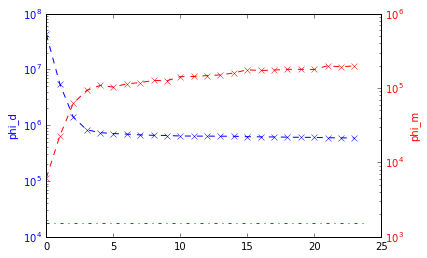

In [46]:
%matplotlib inline
convergeCurves(run1Files)

In [25]:
[res['iter'] for res in run1Files]

[array(11),
 array(1),
 array(9),
 array(5),
 array(8),
 array(4),
 array(6),
 array(7),
 array(10),
 array(2),
 array(3)]

In [7]:
%matplotlib qt
sys.path.append('/home/gudni/Dropbox/code/python/MTview/')
import interactivePlotFunctions as iPf

In [8]:
finData = NSEM.Data(survey,run1Files[0]['dpred']).toRecArray('Complex')

/home/gudni/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:2915: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a structured
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  if (obj.__array_interface__["data"][0]
/home/gudni/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:2916: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a structured
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  != self.__array_interface__["data"][0]):


In [12]:
%matplotlib qt
iPf.MTinteractiveMap([dUse.toRecArray('Complex'),finData])

array([ -1.12913682,  -1.0547609 ,  -0.91376578, ...,  20.59292622,
        21.43811444,  26.946862  ])

### run2

In [13]:
run2Files = loadInversionMakeVTRFiles('run2',mesh,mappingExpAct)

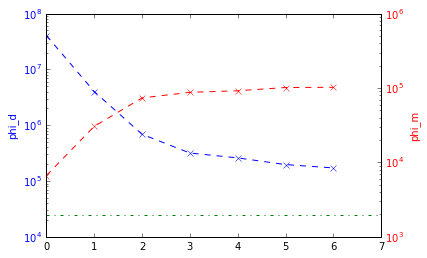

In [14]:
%matplotlib inline
convergeCurves(run2Files)

In [ ]:
finData = NSEM.Data(survey,run2Files[0]['dpred']).toRecArray('Complex')